In [20]:
# 필요한 라이브러리 가져오기
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler

In [29]:
# KOSDAQ 데이터 로드
data = pd.read_csv('코스닥 과거 데이터 (1).csv')  # 실제 파일 경로로 교체
data['날짜'] = pd.to_datetime(data['날짜'], infer_datetime_format=True)
data = data.set_index('날짜')  # '날짜'를 인덱스로 설정
data = data.dropna()  # 누락된 값이 있는 행 삭제

<ipython-input-29-58f05c1cf1a4>:3: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  data['날짜'] = pd.to_datetime(data['날짜'], infer_datetime_format=True)


In [30]:
# 모델링을 위한 데이터 준비
scaler = MinMaxScaler(feature_range=(-1, 1))
price = data[['종가']]
price['종가'] = scaler.fit_transform(price['종가'].values.reshape(-1, 1))

def split_data(stock, lookback):
    data_raw = stock.to_numpy()
    data = []
    for index in range(len(data_raw) - lookback):
        data.append(data_raw[index:index + lookback])
    data = np.array(data)
    test_set_size = int(np.round(0.2 * data.shape[0]))
    train_set_size = data.shape[0] - test_set_size
    x_train = data[:train_set_size, :-1, :]
    y_train = data[:train_set_size, -1, :]
    x_test = data[train_set_size:, :-1]
    y_test = data[train_set_size:, -1, :]
    return [x_train, y_train, x_test, y_test]

lookback = 21 + 1
x_train, y_train, x_test, y_test = split_data(price, lookback)

x_train = torch.from_numpy(x_train).type(torch.Tensor)
y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)

<ipython-input-30-4539caf59d89>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price['종가'] = scaler.fit_transform(price['종가'].values.reshape(-1, 1))


In [31]:
# LSTM 모델 정의
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])
        return out

input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 100

model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [32]:
# 모델 훈련
hist = np.zeros(num_epochs)
for t in range(num_epochs):
    y_train_pred = model(x_train)
    loss = criterion(y_train_pred, y_train_lstm)
    print(f"Epoch {t} MSE: {loss.item()}")
    hist[t] = loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Epoch 0 MSE: 0.24780577421188354
Epoch 1 MSE: 0.1569124311208725
Epoch 2 MSE: 0.09916352480649948
Epoch 3 MSE: 0.14145736396312714
Epoch 4 MSE: 0.09946897625923157
Epoch 5 MSE: 0.08613817393779755
Epoch 6 MSE: 0.08979514986276627
Epoch 7 MSE: 0.09252391010522842
Epoch 8 MSE: 0.089231938123703
Epoch 9 MSE: 0.08000997453927994
Epoch 10 MSE: 0.06675848364830017
Epoch 11 MSE: 0.05417080596089363
Epoch 12 MSE: 0.0511188879609108
Epoch 13 MSE: 0.0527428537607193
Epoch 14 MSE: 0.03521394729614258
Epoch 15 MSE: 0.020373547449707985
Epoch 16 MSE: 0.02053070440888405
Epoch 17 MSE: 0.02167655900120735
Epoch 18 MSE: 0.016867995262145996
Epoch 19 MSE: 0.020247813314199448
Epoch 20 MSE: 0.02216409333050251
Epoch 21 MSE: 0.01442272774875164
Epoch 22 MSE: 0.008944209665060043
Epoch 23 MSE: 0.009615087881684303
Epoch 24 MSE: 0.011306236498057842
Epoch 25 MSE: 0.011317468248307705
Epoch 26 MSE: 0.010393607430160046
Epoch 27 MSE: 0.010002649389207363
Epoch 28 MSE: 0.010415367782115936
Epoch 29 MSE: 0.010

In [33]:
# 테스트 세트에 대한 예측 수행
y_test_pred = model(x_test)

# 예측값과 실제값 역변환
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test_lstm.detach().numpy())

# RMSE 계산
from sklearn.metrics import mean_squared_error
testScore = np.sqrt(mean_squared_error(y_test[:, 0], y_test_pred[:, 0]))
print(f'Test Score: {testScore:.2f} RMSE')

Test Score: 26.24 RMSE


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44201 (\N{HANGUL SYLLABLE GYEOG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51333 (\N{HANGUL SYLLABLE JONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50696 (\N{HANGUL SYLLABLE YE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 52769 (\N{HANGUL SYLLABLE CEUG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-package

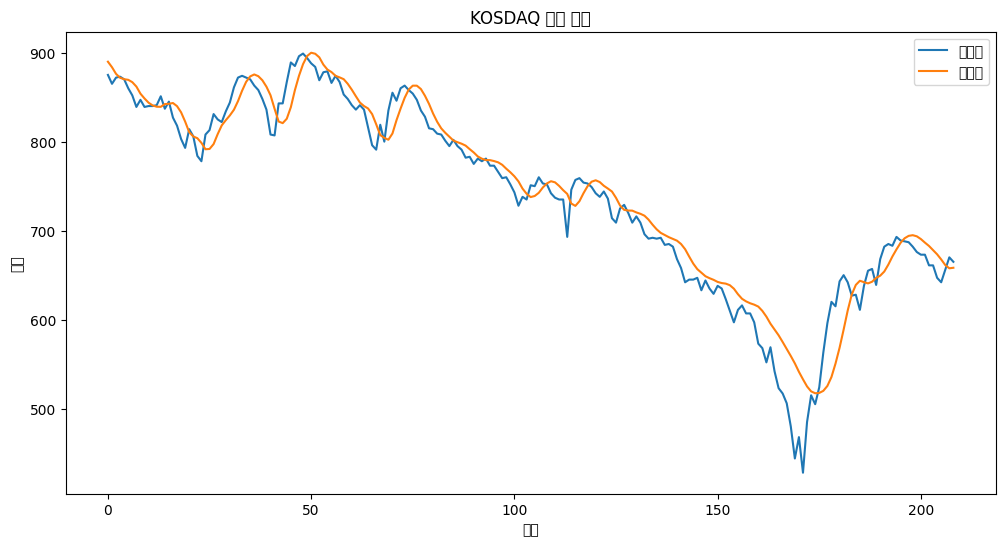

In [34]:
# 실제값과 예측값 그래프 그리기
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='실제값')
plt.plot(y_test_pred, label='예측값')
plt.title('KOSDAQ 종가 예측')
plt.xlabel('시간')
plt.ylabel('가격')
plt.legend()
plt.show()